# 0. Setup

In [20]:
%reload_ext autoreload
%autoreload 2

In [21]:
# Setup
from dotenv import load_dotenv
import os
from langchain_core.messages import HumanMessage
from graph.trivial_agent_graph import IndexerAgentGraphBuilder
from agents.IndexerAgent import indexer_agent_model, tool_executor
from tools.JavaScriptRunner import tool_js_on_block_schema_func, tool_js_on_block_schema
from agents.BlockExtractorAgent import run_js_on_block_only_schema,JsResponse
import json
from IPython.display import Image, display

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

In [22]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage

# Define Graphstate
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: With user questions, tracking plans, reasoning
        block_heights: Block heights of the blocks to be parsed
        js_code: Javascript code to be run on block schema
        block_schema: Extracted block schema from json of blocks 
        ddl_code: Data Definition Language code for creating tables
        dml_code: Data manipulation language code for inserting data using context.db
        iterations: Number of tries to generate the code
        error: error message if any
        should_continue: Binary flag for control flow to indicate whether to continue or not
    """

    messages: Sequence[BaseMessage]
    block_heights: Sequence[int]
    block_schema: str
    js_code: str
    ddl_code: str
    dml_code: str
    iterations: int
    error: str
    should_continue: bool

In [28]:
# Load agents
from tools.NearLake import tool_get_block_heights
from agents.BlockExtractorAgent import BlockExtractorAgent,block_extractor_agent_model_v2
from agents.DDLAgent import DDLCodeAgent,ddl_code_model_v2,DDLResponse
from agents.DMLAgent import DMLCodeAgent,dml_code_model,dml_code_model_v2
from langgraph.prebuilt import ToolExecutor

# Block Extractor Agent
block_extractor_tools = [tool_js_on_block_schema_func] #,tool_get_block_heights]
block_extractor_model = block_extractor_agent_model_v2(block_extractor_tools) # v2 adds the jsresponse parser to prompt
block_extractor_agent = BlockExtractorAgent(block_extractor_model,ToolExecutor(block_extractor_tools))

# DDL Agent
ddl_tools= [] #[tool_js_on_block_schema]
ddl_code_agent_model = ddl_code_model_v2(ddl_tools)
ddl_code_agent = DDLCodeAgent(ddl_code_agent_model,ToolExecutor(ddl_tools))

# DML Agent
dml_tools = []
dml_code_agent_model = dml_code_model(dml_tools)  # uses documentation
# dml_code_agent_model = dml_code_agent_model_v2(dml_tools) #v2 uses 1-shot
dml_code_agent = DMLCodeAgent(dml_code_agent_model,ToolExecutor(dml_tools))

# 1. Block Extractor Agent

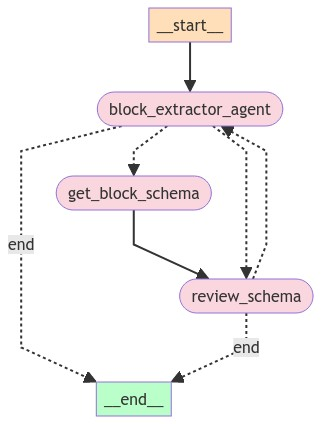

In [29]:
# Define conditional logic
def block_extractor_agent_router(state):
    block_schema = state['block_schema']
    js_code = state['js_code']
    last_message = state["messages"][-1]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "get_block_schema"
    elif js_code != "":
        return "review_schema"
    elif block_schema != "":
        return "review_schema"
    else:
        return "end"
    
def schema_review_router(state):
    should_continue = state['should_continue']
    if should_continue==True:
        return "end"
    else:
        return "block_extractor_agent"
        

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)

## Tool Nodes
workflow.add_node("get_block_schema",block_extractor_agent.call_tool)

## Human Review
workflow.add_node("review_schema",block_extractor_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
# workflow.add_edge("get_block_schema", "block_extractor_agent")
workflow.add_edge("get_block_schema", "review_schema")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "block_extractor_agent",
    block_extractor_agent_router,
    {
        "get_block_schema":"get_block_schema",
        "review_schema": "review_schema",
        "end": END,
    }   
)
# Human review of schema
workflow.add_conditional_edges(
    "review_schema",
    schema_review_router,
    {
        "block_extractor_agent": "block_extractor_agent",
        "end": END,
    }   
)

be_app = workflow.compile()
display(Image(be_app.get_graph(xray=True).draw_mermaid_png()))

In [30]:
from langchain_core.messages import HumanMessage

question = "Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts."

result = be_app.invoke({"messages": [HumanMessage(content=question)], 
                     "block_schema": "",
                     "js_code":"",
                     "ddl_code":"",
                     "dml_code": "",
                     "iterations": 0,
                     "error":"",
                     "should_continue": False,
                     })

print(result)

{'messages': [HumanMessage(content="Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts."), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_plCc2arwcchR0g5elGv7i5aZ', 'function': {'arguments': '{"receiver":"app.nearcrowd.near","from_days_ago":5,"limit":5}', 'name': 'tool_get_block_heights'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-66d4b35b-9868-4f6e-b450-63e593fa9422-0', tool_calls=[{'name': 'tool_get_block_heights', 'args': {'receiver': 'app.nearcrowd.near', 'from_days_ago': 5, 'limit': 5}, 'id': 'call_plCc2arwcchR0g5elGv7i5aZ'}]), ToolMessage(content='[120097595, 120097600, 120097601, 120097605, 120097609]', name='tool_get_block_heights', tool_call_id='call_plCc2arwcchR0g5elGv7i5aZ'), Hu

In [34]:
print(result['js_code'].replace('\\n', '\n'))

function extractData(block) {
    const actions = block.actions();
    receipts = block.receipts();
    header = block.header();
    successfulReceiptIds = new Set(receipts.filter(r => r.status and r.status.SuccessValue).map(r => r.receiptId));
    results = [];
    actions.forEach(action => {
        action.operations.forEach(op => {
            if (op.FunctionCall and successfulReceiptIds.has(action.receiptId) and action.receiverId === 'app.nearcrowd.near') {
                args = JSON.parse(atob(op.FunctionCall.args));
                results.push({
                    signerId: action.signerId,
                    blockHeight: header.height,
                    receiptId: action.receiptId,
                    blockDatetime: new Date(parseInt(header.timestampNanosec) / 1000000).toISOString(),
                    methodName: op.FunctionCall.methodName,
                    ...args
                });
            }
        });
    });
    return results;
}


In [35]:
from tools.JavaScriptRunner import run_js_on_block_only_schema, run_js_on_block

code = result['js_code'].replace('\\n', '\n')

print(json.dumps(run_js_on_block(119688212, code)))

"('evaluateWithContext', 'SyntaxError: missing ) after argument list\\n    at Object.evaluateWithContext (/Users/spark_near/Library/Python/3.9/lib/python/site-packages/javascript/js/bridge.js:70:29)\\n    at Bridge.call (/Users/spark_near/Library/Python/3.9/lib/python/site-packages/javascript/js/bridge.js:136:42)\\n    at Bridge.onMessage (/Users/spark_near/Library/Python/3.9/lib/python/site-packages/javascript/js/bridge.js:231:25)\\n    at Socket.<anonymous> (/Users/spark_near/Library/Python/3.9/lib/python/site-packages/javascript/js/bridge.js:292:18)\\n    at Socket.emit (node:events:520:28)\\n    at addChunk (node:internal/streams/readable:559:12)\\n    at readableAddChunkPushByteMode (node:internal/streams/readable:510:3)\\n    at Readable.push (node:internal/streams/readable:390:5)\\n    at Pipe.onStreamRead (node:internal/stream_base_commons:191:23)')"


# 2. DDL Agent

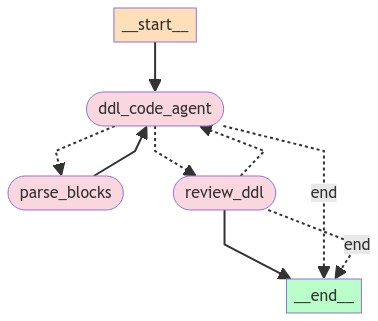

In [47]:
def ddl_code_agent_router(state):
    ddl_code = state['ddl_code']
    iterations = state['iterations']
    last_message = state["messages"][-1]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "parse_blocks"
        else:
            return "review_ddl"
    elif iterations > 3:
        return "end"
    elif ddl_code == "":
        return "ddl_code_agent"
    else:
        return "end"

def ddl_review_continue(state):
    should_continue = state['should_continue']
    iterations = state['iterations']
    if should_continue == True:
        return "end"
    elif iterations > 3:
        return "end"
    else:
        return "ddl_code_agent"

## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)  # Plan the process

## Tool Nodes
workflow.add_node("parse_blocks",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_ddl",ddl_code_agent.human_review)

## Add Edges
workflow.set_entry_point("ddl_code_agent")
workflow.add_edge("parse_blocks", "ddl_code_agent")
workflow.add_edge("review_ddl", END)

# Add Conditional Edges
# Check if tools need to be run
workflow.add_conditional_edges(
    "ddl_code_agent",
    ddl_code_agent_router,
    {
        "parse_blocks":"parse_blocks",
        "review_ddl":"review_ddl",
        "end": END,
    }   
)
# Check if review passed
workflow.add_conditional_edges(
    "review_ddl",
    ddl_review_continue,
    {
        "ddl_code_agent":"ddl_code_agent",
        "end": END,
    }   
)

ddl_app = workflow.compile()

display(Image(ddl_app.get_graph(xray=True).draw_mermaid_png()))

In [48]:
from tools.JavaScriptRunner import run_js_on_block_only_schema, run_js_on_block
js_code = """
function extractData(block) {
    const actions = block.actions();
    const receipts = block.receipts();
    const header = block.header();

    const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);
    const filteredActions = actions.filter(action => action.receiverId === 'app.nearcrowd.near' && action.operations.some(op => op.FunctionCall));

    const result = [];

    for (const action of filteredActions) {
      for (const operation of action.operations) {
        if (operation.FunctionCall) {
          const receipt = receipts.find(receipt => receipt.receiptId === action.receiptId);
          if (receipt) {
            const args = JSON.parse(atob(operation.FunctionCall.args));
            result.push({
              signerId: action.signerId,
              blockHeight: header.height,
              receiptId: action.receiptId,
              receipt: receipt,
              blockDatetime: new Date(parseInt(header.timestampNanosec) / 1000000),
              methodName: operation.FunctionCall.methodName,
              ...args
            });
          }
        }
      }
    }

    return result;
  }
  return extractData(block);
"""
block_schema = json.dumps(run_js_on_block(119688212, js_code))
print(block_schema)

[{"signerId": "app.nearcrowd.near", "blockHeight": 119688212, "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receipt": {"receiptKind": "Data", "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receiverId": "app.nearcrowd.near", "predecessorId": "app.nearcrowd.near", "status": {"SuccessValue": ""}, "executionOutcomeId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "logs": []}, "blockDatetime": "2024-05-25T06:05:09.183Z", "methodName": "finalize_challenged_task", "task_ordinal": 1, "task_hash": [72, 71, 99, 6, 192, 125, 179, 117, 56, 229, 134, 171, 164, 113, 202, 224, 134, 94, 128, 164, 179, 16, 26, 219, 5, 213, 32, 80, 108, 145, 244, 169]}]


In [49]:
from langchain_core.messages import HumanMessage

question = f"""
    Take this block schema and generate DDL code to create normalized Postgresql tables for the data extracted from the block: {block_schema}
"""

result = ddl_app.invoke({"messages": [HumanMessage(content=question)], 
                     "block_schema": "",
                     "js_code":"",
                     "ddl_code":"",
                     "dml_code": "",
                     "iterations": 0,
                     "error":"",
                     "should_continue": False,
                     })

print(result)

{'messages': [HumanMessage(content='\n    Take this block schema and generate DDL code to create normalized Postgresql tables for the data extracted from the block: [{"signerId": "app.nearcrowd.near", "blockHeight": 119688212, "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receipt": {"receiptKind": "Data", "receiptId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "receiverId": "app.nearcrowd.near", "predecessorId": "app.nearcrowd.near", "status": {"SuccessValue": ""}, "executionOutcomeId": "BoTzzQ7okeX3o49qRqAuJaBguzy4q6GMySraZQ4HffxB", "logs": []}, "blockDatetime": "2024-05-25T06:05:09.183Z", "methodName": "finalize_challenged_task", "task_ordinal": 1, "task_hash": [72, 71, 99, 6, 192, 125, 179, 117, 56, 229, 134, 171, 164, 113, 202, 224, 134, 94, 128, 164, 179, 16, 26, 219, 5, 213, 32, 80, 108, 145, 244, 169]}]\n'), SystemMessage(content="ddl='CREATE TABLE IF NOT EXISTS block_data (\\n    signer_id VARCHAR(255),\\n    block_height BIGINT,\\n    receipt_id VARCHAR(25

In [51]:
print(result['ddl_code'])

CREATE TABLE IF NOT EXISTS block_data (
    signer_id VARCHAR(255),
    block_height BIGINT,
    receipt_id VARCHAR(255),
    receipt_kind VARCHAR(255),
    receiver_id VARCHAR(255),
    predecessor_id VARCHAR(255),
    status_success_value VARCHAR(255),
    execution_outcome_id VARCHAR(255),
    logs JSONB,
    block_datetime TIMESTAMP,
    method_name VARCHAR(255),
    task_ordinal INTEGER,
    task_hash BYTEA,
    PRIMARY KEY (receipt_id)
);


# 3. DML Agent

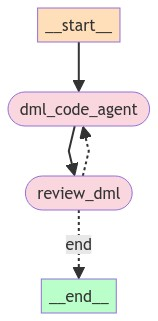

In [31]:
def dml_code_agent_router(state):
    should_continue = state['should_continue']
    iterations = state['iterations']
    if should_continue == True:
        return "end"
    elif iterations > 3:
        return "end"
    else:
        return "dml_code_agent"
    
## Create DDL Graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("dml_code_agent", dml_code_agent.call_model)  # Plan the process

## Human Review
workflow.add_node("review_dml",dml_code_agent.human_review)

## Add Edges
workflow.set_entry_point("dml_code_agent")
workflow.add_edge("dml_code_agent","review_dml")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "review_dml",
    dml_code_agent_router,
    {
        "dml_code_agent":"dml_code_agent",
        "end": END,
    }   
)

dml_app = workflow.compile()
display(Image(dml_app.get_graph(xray=True).draw_mermaid_png()))

In [32]:
psql = {
    "ddl": "CREATE TABLE IF NOT EXISTS block_data (\n    signer_id VARCHAR(255),\n    block_height BIGINT,\n    receipt_id VARCHAR(255) PRIMARY KEY,\n    receipt_kind VARCHAR(255),\n    receiver_id VARCHAR(255),\n    predecessor_id VARCHAR(255),\n    status_value VARCHAR(255),\n    execution_outcome_id VARCHAR(255),\n    logs JSONB,\n    block_datetime TIMESTAMP,\n    method_name VARCHAR(255),\n    task_ordinal INTEGER,\n    task_hash BYTEA\n);"
}
psql_schema = psql['ddl']
print(psql_schema)

CREATE TABLE IF NOT EXISTS block_data (
    signer_id VARCHAR(255),
    block_height BIGINT,
    receipt_id VARCHAR(255) PRIMARY KEY,
    receipt_kind VARCHAR(255),
    receiver_id VARCHAR(255),
    predecessor_id VARCHAR(255),
    status_value VARCHAR(255),
    execution_outcome_id VARCHAR(255),
    logs JSONB,
    block_datetime TIMESTAMP,
    method_name VARCHAR(255),
    task_ordinal INTEGER,
    task_hash BYTEA
);


In [35]:
# from langchain_core.messages import HumanMessage

# question = f"""
#     Take this Postgresql schema and Javascript function for parsing parse blocks and generate DML code to upsert data into Postgresql tables.
#     Postgresql schema: {psql_schema}
#     Javascript Function: {js_code}
# """

# result = dml_app.invoke({"messages": [HumanMessage(content=question)], 
#                      "block_schema": "",
#                      "js_code":"",
#                      "ddl_code":"",
#                      "dml_code": "",
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result)

{'messages': [HumanMessage(content="\n    Take this Postgresql schema and Javascript function for parsing parse blocks and generate DML code to upsert data into Postgresql tables.\n    Postgresql schema: CREATE TABLE IF NOT EXISTS block_data (\n    signer_id VARCHAR(255),\n    block_height BIGINT,\n    receipt_id VARCHAR(255) PRIMARY KEY,\n    receipt_kind VARCHAR(255),\n    receiver_id VARCHAR(255),\n    predecessor_id VARCHAR(255),\n    status_value VARCHAR(255),\n    execution_outcome_id VARCHAR(255),\n    logs JSONB,\n    block_datetime TIMESTAMP,\n    method_name VARCHAR(255),\n    task_ordinal INTEGER,\n    task_hash BYTEA\n);\n    Javascript Function: \nfunction extractData(block) {\n    const actions = block.actions();\n    const receipts = block.receipts();\n    const header = block.header();\n\n    const successfulReceipts = receipts.filter(receipt => receipt.status.SuccessValue);\n    const filteredActions = actions.filter(action => action.receiverId === 'app.nearcrowd.near'

In [36]:
# print(result["messages"][-1].content)

dml="try {\n  const data = extractData(block);\n  for (const item of data) {\n    await context.db.block_data.upsert([\n      {\n        signer_id: item.signerId,\n        block_height: item.blockHeight,\n        receipt_id: item.receiptId,\n        receipt_kind: item.receipt.kind,\n        receiver_id: item.receipt.receiverId,\n        predecessor_id: item.receipt.predecessorId,\n        status_value: item.receipt.status.SuccessValue,\n        execution_outcome_id: item.receipt.executionOutcome.id,\n        logs: item.receipt.logs,\n        block_datetime: item.blockDatetime,\n        method_name: item.methodName,\n        task_ordinal: item.taskOrdinal,\n        task_hash: item.taskHash\n      }\n    ], ['receipt_id'], ['block_height', 'receipt_kind', 'receiver_id', 'predecessor_id', 'status_value', 'execution_outcome_id', 'logs', 'block_datetime', 'method_name', 'task_ordinal', 'task_hash']);\n  }\n} catch (e) {\n  console.error(`Error upserting data: ${e}`);\n}" explanation='Added 

In [40]:
# print(result['dml_code'])

try {
  const data = extractData(block);
  for (const item of data) {
    await context.db.block_data.upsert([
      {
        signer_id: item.signerId,
        block_height: item.blockHeight,
        receipt_id: item.receiptId,
        receipt_kind: item.receipt.kind,
        receiver_id: item.receipt.receiverId,
        predecessor_id: item.receipt.predecessorId,
        status_value: item.receipt.status.SuccessValue,
        execution_outcome_id: item.receipt.executionOutcome.id,
        logs: item.receipt.logs,
        block_datetime: item.blockDatetime,
        method_name: item.methodName,
        task_ordinal: item.taskOrdinal,
        task_hash: item.taskHash
      }
    ], ['receipt_id'], ['block_height', 'receipt_kind', 'receiver_id', 'predecessor_id', 'status_value', 'execution_outcome_id', 'logs', 'block_datetime', 'method_name', 'task_ordinal', 'task_hash']);
  }
} catch (e) {
  console.error(`Error upserting data: ${e}`);
}


# 4. Full Graph

In [ ]:
# Conditional Edge logic
def should_block_schema_continue(state):
    last_message = state["messages"][-1]
    messages = state["messages"]
    if hasattr(last_message, 'additional_kwargs'):
        if "tool_calls" in last_message.additional_kwargs:
            return "continue"
        else:
            return "end"
    else:
        return "end"
    
def block_schema_review_continue(state):
    should_continue = state['should_continue']
    block_schema = state['block_schema']
    iterations = state['iterations']
    if should_continue == True:
        return "continue"
    elif iterations > 3:
        return "end"
    elif block_schema == "":
        return "repeat"
    else:
        return "end"
    

In [ ]:
## Create Final Graph (will move this to another file ultimately)
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

## Define the Agent nodes
workflow.add_node("block_extractor_agent", block_extractor_agent.call_model)  # Plan the process
workflow.add_node("ddl_code_agent", ddl_code_agent.call_model)  # Plan the process

## Tool Nodes
workflow.add_node("get_block_schema",block_extractor_agent.call_tool)
workflow.add_node("parse_blocks",ddl_code_agent.call_tool)

## Human Review
workflow.add_node("review_schema",block_extractor_agent.human_review)

## Add Edges
workflow.set_entry_point("block_extractor_agent")
workflow.add_edge("get_block_schema", "review_schema")
workflow.add_edge("parse_blocks", "ddl_code_agent")

# Add Conditional Edges
# Check if all block extraction tools are completed
workflow.add_conditional_edges(
    "block_extractor_agent",
    should_block_schema_continue,
    {
        "continue":"get_block_schema",
        "end": "ddl_code_agent"
    }   
)
# Check if block schema is correct via human review
workflow.add_conditional_edges(
    "review_schema",
    block_schema_review_continue,
    {
        "continue":"ddl_code_agent",
        "repeat": "block_extractor_agent",
        "end": END
    }   
)
# Check if DDL has finished tool calls
workflow.add_conditional_edges(
    "ddl_code_agent",
    should_block_schema_continue,
    {
        "continue":"parse_blocks",
        "end": END
    }   
)

app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# from langchain_core.messages import HumanMessage

# question = """
#     Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, 
#     I need signerId, block height, receiptId, block datetime, methodName. Also add all fields from 
#     args that are decoded from base64-encoded JSON. I only need actions for successful receipts.
# """

# result = app.invoke({"messages": [HumanMessage(content=question)], 
#                      "block_schema": "",
#                      "js_code":"",
#                      "ddl_code":"",
#                      "dml_code": "",
#                      "iterations": 0,
#                      "error":"",
#                      "should_continue": False,
#                      })

# print(result)

# Notes
### 1. Forced Schema Output
- This is determined at the model level, we have 2 options

a. Add .partial to the prompt - this is NON-deterministic

`dml_parser = PydanticOutputParser(pydantic_object=DMLResponse)`

`prompt(<PROMPT>).partial(format_instructions=dml_parser.get_format_instructions())`

b. When creating the model in LCEL - this IS deterministic

`model = {"messages": RunnablePassthrough()} | prompt | llm.with_structured_output(DMLResponse)`

Note: if you do this, you have to make sure to wrap the response in a SystemMessage

`response = self.model.invoke(messages)`

`wrapped_message = SystemMessage(content=str(response))`


**When agents perform parallel tool calling, we want to use a, when agents just spit out code, we want b.**

### 2. Issues with reliable JS block parsing generation and execution
- I'm not getting reliable JS code that can be run from block extractor agent
- Even when hard coding working JS code into DDL agent, I'm not able to reliably parse block schema with the JS using tool call
- We have to be careful about string replacement: \n, and {} mess a lot of stuff up